### Document Image Segmentation Workflow: 
- Extracting Individual Words with Bounding Boxes Using Image Processing

In [ ]:
!pip install matplotlib opencv-python scikit-image numpy pandas

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.transform import resize
from skimage.filters import *
from skimage import exposure
import pandas as pd

import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color, img_as_ubyte
import os

# Parameters to adjust for finetuning the segmentation
resize_resolution = (1080, 500)             # Resize resolution of the document
gaussian_blur_kernel = (3, 3)               # Gaussian filter kernel size
gamma_adjust = 0.8                          # Adjust gamma of the image

dilation_iters = 4                          # Count of iterations of dilation opertion
dilation_structuring_element = (10, 3)      # Dimensions of the custom dilation element => Rectangular 

min_area = 100                              # Minimum area of a word to filter the noise


cntr = 0
# Preprocess the Document image
def preprocess_image(img):
    """
        Image Preprocessing - Image Resize, Apply Gaussian Blur, Adjust gamma
    """
    # Perform Image resizing
    img = cv2.resize(img, resize_resolution, interpolation = cv2.INTER_AREA)
    # Apply Gaussian Blur to smoothen image and remove noize
    img = cv2.GaussianBlur(img, gaussian_blur_kernel, 0)
    # Adjust gamma in the image
    img = exposure.adjust_gamma(img, gamma_adjust)
    return img

# Binirize the Document image
def local_thresholding(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.array(img)
    block_size = 35
    local_thresh = threshold_local(img, block_size, offset=10)
    binary_local = img > local_thresh
    img = np.array(binary_local).astype(np.uint8)
    return img

# Remove Horizontal lines present in the Document (Optional)
def remove_lines(img):
    # Horizontal lines
    lines = np.ones(img.shape)
    lines = lines.astype(np.uint8)
    
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,2))
    detected_lines = cv2.morphologyEx(img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(lines, [c], -1, 0, 8)
    img = cv2.subtract(lines, img)
    return img


# Custom dilation to combine individual letters of the word
def custom_dilation(img):
    """
        Perform morphological operation - Dilation with customized structuring element and cleanup the border pixels of the Image
    """
    kernel = np.ones((3, 3), np.uint8)
    img = cv2.erode(img, kernel)
    # Define custom rectangular structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, dilation_structuring_element)
    # Perform morphological dilation on the image for multiple iterations
    img = cv2.dilate(img, kernel, iterations=dilation_iters)
    # Clean the border pixels of the image
    img[0:25, :] = 0
    img[:, 0:25] = 0
    img[:, len(img[0])-25:len(img[0])-1] = 0
    img[len(img)-25:len(img)-1,: ] = 0
    return img

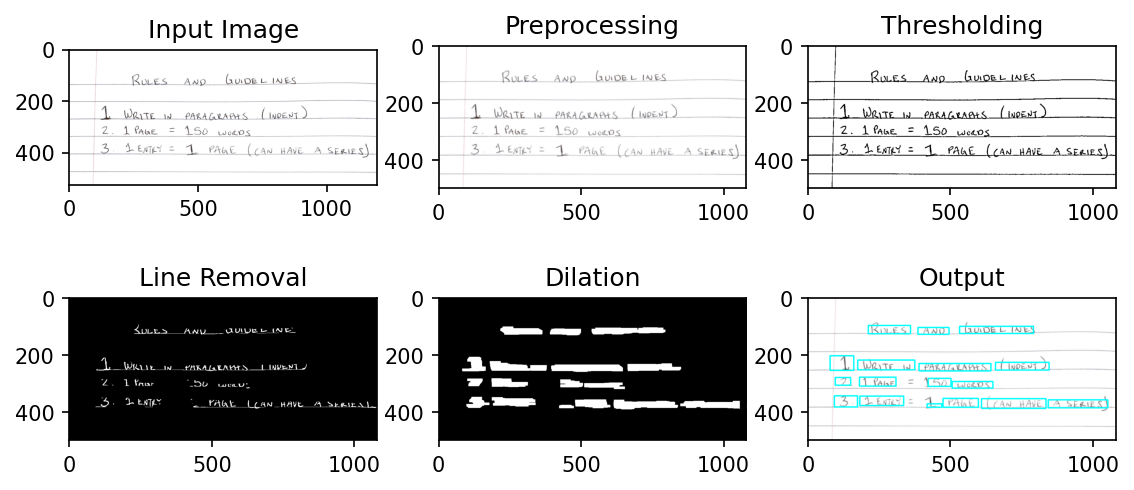

In [3]:
import os
from collections import Counter
from skimage import morphology
from glob import glob

for i, image in enumerate(glob('Resourses/test.png')):
    fig, ax = plt.subplots(2, 3, figsize=(9, 4), dpi=150)

    input_image = cv2.imread(image)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    ax[0][0].imshow(input_image)
    ax[0][0].title.set_text("Input Image")
    
    prep_image = preprocess_image(input_image)
    ax[0][1].imshow(prep_image)
    ax[0][1].title.set_text("Preprocessing")

    thresh = local_thresholding(prep_image)
    ax[0][2].imshow(thresh, cmap="gray")
    ax[0][2].title.set_text("Thresholding")
    
    thresh = remove_lines(thresh)
    ax[1][0].imshow(thresh, cmap="gray")
    ax[1][0].title.set_text("Line Removal")

    dilation = custom_dilation(thresh)
    ax[1][1].imshow(dilation, cmap='gray')
    ax[1][1].title.set_text("Dilation")
    
    max_area = (len(prep_image[0])-30) * (len(prep_image)-30)
    cnts, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    bbox_image = prep_image.copy()
    
    cntr = 1
    for cntr in cnts:
        cntr += 1
        area = cv2.contourArea(cntr)
        # Small object Removal
        if area < min_area or area > max_area:
            continue
            
        # Bounding Box around word
        x, y, w, h = cv2.boundingRect(cntr)
        cv2.rectangle(bbox_image, (x-5, y-5), ((x + w) - 5, (y + h) -5), (0, 255, 255), 3)
        word = prep_image[y:y+h, x:x+w]
#         cv2.imwrite(f"./words/{i}_{cntr}.jpg", word)

    ax[1][2].imshow(bbox_image, cmap='gray')
    ax[1][2].title.set_text("Output")